# Database 5

## M:N (User-User)  


<b>개요</b>

User 자기 자신과의 M:N 관계 설정을 통한 팔로우 기능 구현하기

ex) follower

### Profile

<b>개요</b>  

자연스러운 follow 흐름을 위한 프로필 페이지를 먼저 작성

<b>Profile 구현</b>  

url 및 view 함수 작성  

```py
# accounts/urls.py

urlpatterns = [
    ...
    path('<str:username>/', views.profile, name = "profile"),
]

```

```py
# accounts/views.py

from django.contrib.auth import get_user_model

def profile(request, username):
    User = get_user_model()
    person = User.objects.get(username=username)
    context = {'person': person,}
    
    return render(request, 'accounts/profile.html', context)
```

profile 템플릿 작성  

```html
<!-- accounts/templates/accounts/profile.html -->

{% extends 'base.html' %}

{% block content %}
  <h1>{{ person.username }} 님의 프로필</h1>

  <hr>

  <h2>{{ person.username }}'s 게시글</h2>
  {% for article in person.article_set.all  %}
    <div>{{ article.title }}</div>
  {% endfor %}

  <hr>
  
  <h2>{{ person.username }}'s 댓글</h2>
  {% for comment in person.comment_set.all  %}
    <div>{{ comment.content }}</div>
  {% endfor %}

  <hr>

  <h2>{{ person.username }}'s 좋아요한 게시글</h2>
  {% for article in person.like_articles.all %}
    <div>{{ article.title }}</div>
  {% endfor %}

  <hr>

  <a href="{% url 'articles:index' %}">BACK</a>
{% endblock content %}
```

<hr>

```html
<!-- accounts/templates/accounts/profile.html -->
<!-- 업그레이드 버전 -->

{% extends 'base.html' %}

{% block content %}
  <h1>{{ person.username }} 님의 프로필</h1>

  <hr>

  <h2>{{ person.username }}'s 게시글</h2>
  {% for article in person.article_set.all  %}
    {% comment %} <div>{{ article.title }}</div> {% endcomment %}
    {% comment %} <a href="{% url 'articles:detail' article.pk %}">{{ article.title }}</a>   {% endcomment %}
    <div class='card'>
      <div class='card-body'>
        <h5 class='card-title'>{{ article.title }}</h5>
        <p class = 'card-text'>{{ article.content }}</p>
        <a href="{% url 'articles:detail' article.pk %}" class="btn btn-primary">자세히 보기</a>
      </div>
    </div>
  {% endfor %}

  <hr>
  
  <h2>{{ person.username }}'s 댓글</h2>
  {% for comment in person.comment_set.all  %}
    <div>{{ comment.content }}</div>
  {% endfor %}

  <hr>

  <h2>{{ person.username }}'s 좋아요한 게시글</h2>
  {% for article in person.like_articles.all %}
    {% comment %} <div>{{ article.title }}</div> {% endcomment %}
    <div class='card'>
      <div class='card-body'>
        <h5 class='card-title'>{{ article.title }}</h5>
        <p class = 'card-text'>{{ article.content }}</p>
        <a href="{% url 'articles:detail' article.pk %}" class="btn btn-primary">자세히 보기</a>
      </div>
    </div>
  {% endfor %}
  
  <hr>
  
  <a href="{% url 'articles:index' %}" class='btn btn-success'>BACK</a>
{% endblock content %}
```

profile 템플릿으로 이동할 수 있는 하이퍼링크 작성  

```html
<!-- templates/base.html -->

...
    <h3 id="user-hello">
        <i>안녕하세요, <a href="{% url 'accounts:profile' user.username %}">{{user}}</a> 님 !</i>
    </h3>
...
```

```html
<!-- articles/index.html -->

...
    <p>
      [{{article.id}}] 
      <a href="{% url 'articles:detail' article.pk %}" id="article-title">{{article.title}}</a>
      - 작성자: <a href="{% url 'accounts:profile' article.user.username %}">{{article.user}}</a>
    </p>
...
```

### Follow

<b>모델 관계 설정</b>  

```py
# accounts/models.py

from django.db import models
from django.contrib.auth.models import AbstractUser

# Create your models here.
class User(AbstractUser):
    followings = models.ManyToManyField('self', symmetrical=False, related_name='followers')
```

내가 상대를 팔로우했다고, 상대도 날 팔로우할 필요는 없다.(symmetrical=False 를 사용하는 이유)

&nbsp;

```bash
$python manage.py makemigrations
$python manage.py migrate
```

생성된 중계 테이블을 확인  
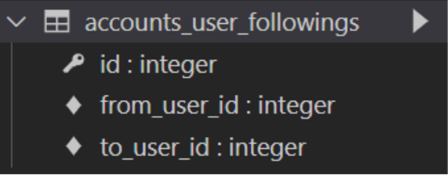

<b>Follow 구현</b>  

url 및 view 함수 작성  

```py
# accounts/urls.py

urlpatterns = [
    ...
    path('<int:user_pk>/follow/', views.follow, name="follow"),
]
```

```py
# accounts/views.py

...
def follow(request, user_pk):
    User = get_user_model()
    person = User.objects.get(pk=user_pk)

    if person != request.user:
        if person.followers.filter(pk=request.user.pk).exists():
        # if request.user in person.followers.all():
            person.followers.remove(request.user)
        else:
            person.followers.add(request.user)

    return redirect('accounts:profile', person.username)
```

<hr>
프로필 유저의 팔로잉, 팔로워 수 & 팔로우, 언팔로우 버튼 작성  

```html  
<!-- accounts/profile.html -->

...
  <h1>{{ person.username }} 님의 프로필</h1>

  <div>
    <div>
      팔로잉 : {{ person.followings.count }} / 팔로워 : {{ person.followers.count }}
    </div>
    {% if request.user != person %}
      <div>
        <form action="{% url 'accounts:follow' person.pk %}" method="POST">
          {% csrf_token %}
          {% if request.user in person.follwers.all %}
            <input type="submit" value="Unfollow">
          {% else %}
            <input type="submit" value="Follow">
          {% endif %}
        </form>
      </div>
    {% endif %}
  </div>
...
```

```html
<!-- accounts/profile.html -->
<!-- 다른 버전 -->
...
  <h1>{{ person.username }} 님의 프로필</h1>

  <div>
    <div>
      팔로잉 : {{ person.followings.count }} / 팔로워 : {{ person.followers.count }}
    </div>
    {% if request.user != person %}
      <div>
        <form action="{% url 'accounts:follow' person.pk %}" method="POST">
          {% csrf_token %}
          {% if request.user in person.followers.all %}
            {% comment %} <input type="submit" value="Unfollow"> {% endcomment %}
            <button type="submit" class="btn btn-danger">언팔로우</button>
          {% else %}
            {% comment %} <input type="submit" value="Follow"> {% endcomment %}
            <button type="submit" class="btn btn-success">팔로우</button>
          {% endif %}
        </form>
      </div>
    {% endif %}
  </div>
...
```

<hr>

데코레이터 및 is_authenticated 추가  

```py
# accounts/views.py

@require_POST
def follow(request, user_pk):
    if request.user.is_authenticated:
        User = get_user_model()
        person = User.objects.get(pk=user_pk)

        if person != request.user:
            if person.followers.filter(pk=request.user.pk).exists():
            # if request.user in person.followers.all():
                person.followers.remove(request.user)
            else:
                person.followers.add(request.user)

        return redirect('accounts:profile', person.username)

    return redirect('accounts:login')
```

# 이 부분 이하는 알면 도움이 되는 부분

### Fixtures

<b>개요</b>  

Fixtures를 사용해 모델에 초기 데이터를 제공하는 방법  

&nbsp;

<b>초기 데이터의 필요성</b>  

협업하는 A, B 유저가 있다고 생각해보자.  

1. A가 먼저 프로젝트를 작업 후 github에 push 한다.
- gitignore 설정으로 인해 DB는 업로드하지 않기 때문에 A가 개발하면서 사용한 데이터는 올라가지 않는다.  

2. B가 github에서 A push한 프로젝트를 pull(혹은 clone)한다.  
- 마찬가지로 프로젝트는 받았지만 A가 생성하고 조작한 데이터는 없는 빈 프로젝트를 받게 된다.  

이처럼 Django 프로젝트의 앱을 처음 설정할 때 동일하게 준비된 데이터로 데이터베이스를 미리 채우는 것이 필요한 순간이 있다.  

Django에서는 fixtures를 사용해 앱에 초기 데이터(initial data)를 제공할 수 있다.  

즉 migrations와 fixtures를 사용하여 data와 구조를 공유하게 된다.  

### Providing data with fixtures  

<b>사전준비</b>  

M:N 까지 모두 작성된 Django 프로젝트에서 유저, 게시글, 댓글, 좋아요 등 각 데이터를 최소 2개 이상 생성해두기  

<b>fixtures</b>  

Django가 데이터베이스로 가져오는 방법을 알고 있는 데이터 모음  

- 가져오는 방법을 알고 있다?
    - Django가 직접 만들기 때문에 데이터베이스 구조에 맞추어 작성되어 있음  

<a href="https://docs.djangoproject.com/en/3.2/howto/initial-data/#providing-data-with-fixtures">https://docs.djangoproject.com/en/3.2/howto/initial-data/#providing-data-with-fixtures</a>

<b>fixtures 생성 및 로드</b>  

생성(데이터 추출)  
- dumpdata

로드 (데이터 입력)  
- loaddata

&nbsp;

<b>dumpdata</b>  

응용 프로그램과 관련된 데이터베이스의 모든 데이터를 표준 출력으로 출력함  

여러 모델을 하나의 json파일로 만들 수 있음  

```bash
# 작성예시

$python manage.py dumdata [app_name[.ModelName] [app_name[.ModelName] ...]] > {filename}.json
```

&nbsp;

articles app의 article 모델에 대한 data를 json 형식으로 저장하기  

```bash
$python manage.py dump --indent 4 articles.article > articles.json
```

manage.py와 동일한 위치에 data가 담긴 articles.json 파일이 생성됨  

dumpdata의 출력 결과물은 loaddata의 입력으로 사용됨  

<font color="red">fixtures 파일은 직접 만드는 것이 아니라 dumpdata를 사용하여 생성하는 것이다.</font>  

&nbsp;

추가로 나머지 모델에 대한 데이터를 dump한다.  

```bash
$python manage.py dumpdata --indent 4 accounts.users > users.json
$python manage.py dumpdata --indent 4 articles.comment > comments.json
```

&nbsp;

<b>[참고] 모든 모델을 한 번에 dump 하기</b>  

```bash
# 3개의 모델을 하나의 json 파일로  
$python manage.py dumpdata --indent 4 articles.article articles.comment accounts.user > data.json

# 모든 모델을 하나의 json 파일로  
$python manage.py dumpdata --indent 4 > data.json
```

<b>loaddata</b>  

fixtures의 내용을 검색하여 데이터베이스로 로드  

```bash
# 작성 예시  

$python manage.py loaddata data.json
```

fixture 기본 경로  
- app_name/fixtures/
- Django는 설치된 모든 app의 디렉토리에서 fixtures 폴더 이후의 경로로 fixtures 파일을 찾음  

&nbsp;

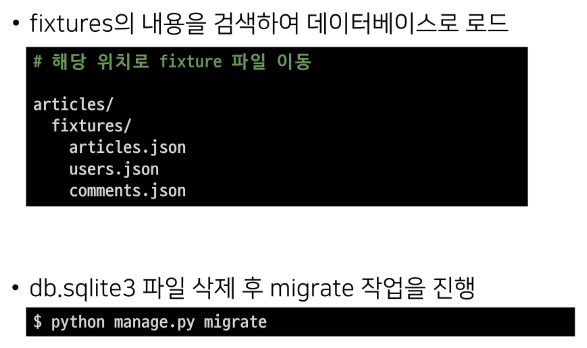

fixtures load 하기  

```bash
$python manage.py loaddata articles.json users.json comments.json
```

load 후 데이터가 잘 입력되었는지 확인하기  

<b>[참고] loaddata를 하는 순서</b>  

loaddata를 한 번에 실행하지 않고 하나씩 실행한다면 모델 관계에 따라 순서가 중요할 수 있음  
- comment는 article에 대한 key 및 users에 대한 key가 필요  
- article은 user에 대한 key가 필요  

즉, 현재 모델 관계에서 user -> article -> comment 순으로 data를 넣어야 오류가 발생하지 않음  

```bash
$python manage.py loaddata users.json
$python manage.py loaddata articles.json
$python manage.py loaddata comments.json
```

<b>[참고]loaddata 시 encoing codec 관련 에러가 발생하는 경우</b>  

2가지 방법 중 택 1

1. dumpdata 시 추가 옵션 작성  
```bash
$python -Xutf8 manage.py dumpdata [생략]
```

2. 메모장 활용
    1. 메모장으로 json 파일 열기
    2. "다른 이름으로 저장" 클릭
    3. 인코딩을 UTF8로 선택 후 저장  

<b>fixtures 정리</b>  

fixtures 파일은 직접 만드는 것이 아니라 dumpdata를 사용하여 생성하는 것  

### Improve Query 

<b>섣부른 최적화를 하지 말자</b>  

"작은 효율성(small efficiency)에 대해서는, 말하자면 97% 정도에 대해서는,  
잊어버려라. 섣부른 최적화(premature optimization)는 모든 악의 근원이다."  

- 도널드 커누스(Donald E. Knuth)

<b>사전준비</b>  

프로젝트 생성(query_pjt)  

앱 생성(myapp)  

모델 생성  

```py
# myapp/models.py

from django.db import models

# Create your models here.
class PetSitter(models.Model):
    first_name = models.CharField(max_length=50)
    last_name = models.CharField(max_length=50)
    age = models.IntegerField()

    def __str__(self):
        return f"집사 {self.first_name}"


class Pet(models.Model):
    name = models.CharField(max_length=50)
    pet_sitter = models.ForeignKey(PetSitter, on_delete=models.CASCADE)

    def __str__(self):
        return f"{self.name}"
```

<b>모든 Pet의 집사 이름을 출력하고 싶다면?</b>  

```py
# myapp/views.py

from django.shortcuts import render
from .models import PetSitter, Pet

def get_pet_data():
    pets = Pet.objects.all()
    for pet in pets:
        print(f"{pet.name} | 집사 {pet.pet_sitter.first_name}")
 ```

Django Shell 켜고 실행
 ```bash
 from myapp.views import get_pet_data
 get_pet_data()
 ```

ORM 안쓰고 직접 SQL로 데이터를 가져온다면?  
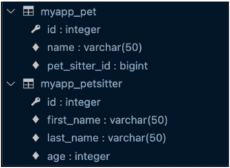

 ```sql
SELECT "myapp_pet"."name", "myapp_petsitter"."first_name" FROM "myapp_pet" INNER JOIN "myapp_petsitter"
ON ("myapp_pet"."pet_sitter_id" = "myapp_petsitter"."id");
 ```

 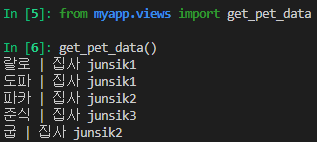

과연 ORM은 몇 버 데이베이스를 조회했을까?  

```py
# myapp/views.py

from django.shortcuts import render
from .models import PetSitter, Pet
from django.db import connection, reset_queries

# Create your views here.
def get_pet_data():
    reset_queries()

    pets = Pet.objects.all()
    for pet in pets:
        print(f"{pet.name} | 집사 {pet.pet_sitter.first_name}")

    query_info = connection.queries
    for query in query_info:
        print(query['sql'])
```
<hr>

```py
# myapp/views.py
# 데코레이터 버전

def get_sql_queries(origin_func):
    def wrapper(*args, **kwargs):
        reset_queries()
        origin_func(*args, **kwargs)
        query_info = connection.queries
        for query in query_info:
            print(query['sql'])

    return wrapper


@get_sql_queries
def get_pet_data():
    pets = Pet.objects.all()
    for pet in pets:
        print(f"{pet.name} | 집사 {pet.pet_sitter.first_name}")

```
Django shell 켜고 실행

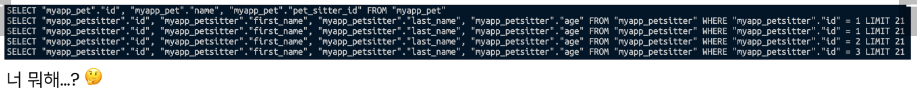

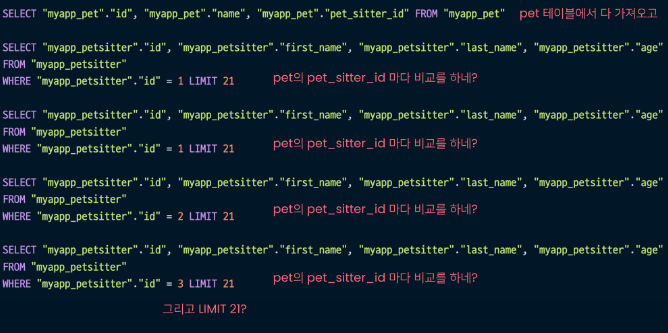

N + 1 Problem : 내가 원하는 데이터를 조회하기 위해서 한 번의 쿼리에 대해서 N개의 쿼리가 추가적으로 나가는 것

<b>Django ORM</b>  

Pros
- SQL을 몰라도 된다.
- SQL을 사용하는 대신 객체 지향적으로 데이터를 조회할 수 있다.  
- 재사용, 유지보수 쉽다.  
- DBMS에 대한 의존도가 떨어진다.  

Cons
- 복잡한 SQL문을 그대로 재현하기 어려움  
- 멋모르고 사용하면 이상한 쿼리 나감 <font color='red'>N + 1 Problem이 대표적</font>  

<b>Django ORM 특징</b>  

Django ORM은 기본적으로 <font color="red">Laze Loading</font> 전략을 사용한다.  

== ORM을 작성하면 Dabase에 Query하는 것이 아니라,  
&emsp; 미루고 미루다가 실제로 데이터를 사용할 때!
&emsp; Database에 Query를 날린다.  

== ORM 함수를 호출할 때가 아닌, Queryset이 실제로 평가될 때 DB를 호출한다.  
== Queryset이 실제로 모습을 드러내야 할 때 DB를 부른다는 것 !
&emsp; print, slicing, len, list, iteration ...

똑같은 데이터를 사용한다면 <font color="red">캐싱</font>을 내부적으로 해둔다.  

<b>Laze Loading(지연 로딩)</b>  

Django ORM은 기본적으로 Laze Loading 전략을 사용한다.  

data = Model.objects.all()
&emsp; 이 때는 DB에 아무런 콜도 하지 않는다.  
&emsp; 그저 sql로 가지고 있을 뿐  

print(data), list(data), first_data = data[0]  
&emsp; 이런 경우 실제로 DB에 콜을 날려서 데이터를 조회한다.  

왜 이렇게  할까?  

    당연히 성능 개선을 위해서!
    객체와 RDB를 연결하는 ORM 입장에서는,  
    객체 코드로 다루는 모든 경우에 호출하는 것은 매우 비용이 많이 드는 작업  
    따라서 실제로 해당 데이터가 필요한 시점에!
    데이터베이스를 호출하는 것  

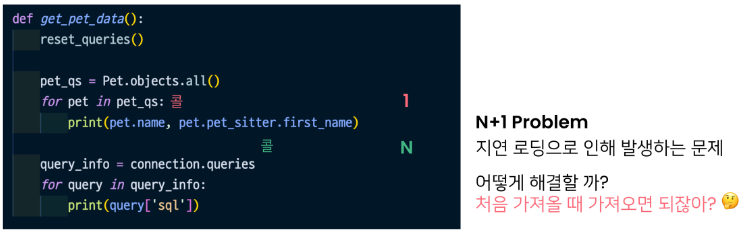

pet에서 pet_sitter까지는 바로 접근할 수 있지만 first_name에는 접근할 수 없다.  
이 때마다 데이터베이스를 콜하다보니 N + 1 쿼리 문제가 발생한다.  

<b>Eager Loading(즉시 로딩)</b>  

Laze Loading: 지금 사용하지 않으면 안 가져옴  
Eager Loading: 지금 사용하지 않더라도 가져와 ! - 보통 여러 테이블의 데이터를 한 번에 가져올 때 사용  

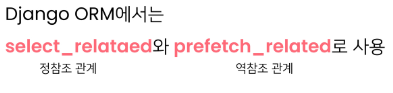

```py
# myapp/views.py

def get_sql_queries(origin_func):
    def wrapper(*args, **kwargs):
        reset_queries()
        origin_func(*args, **kwargs)
        query_info = connection.queries
        for query in query_info:
            print(query['sql'])

    return wrapper


@get_sql_queries
def get_pet_data():
    pets = Pet.objects.all().select_related('pet_sitter')
    for pet in pets:
        print(f"{pet.name} | 집사 {pet.pet_sitter.first_name}")

```

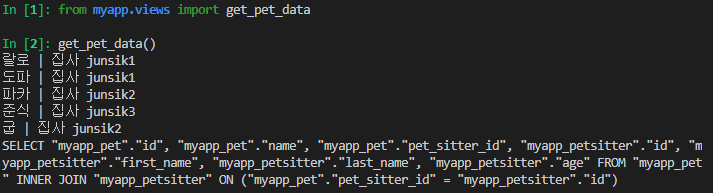

이제 정상적으로 작동한다.(한 번의 쿼리로 작동한다.)  

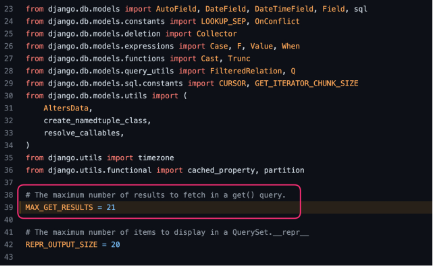

LIMIT 21  
<a href= "https://github.com/django/django/blob/main/django/db/models/query.py#L39">https://github.com/django/django/blob/main/django/db/models/query.py#L39</a>

<b>select_related</b>  

1:1 또는 N:1 참조 관계에서 사용  

SQL에서 INNER JOIN 절을 활용  
- SQL의 INNER JOIN을 사용하여 참조하는 테이블의 일부를 가져오고, SELECT FROM을 통해 관련된 필드를 가져옴  

<b>prefetch_related</b>  

M:N 또는 N:1 역참조 관계에서 사용  

SQL이 아닌 Python을 통한 JOIN이 진행됨  

<b>Django ORM - Caching</b>  

특정 데이터를 불러온 후 재사용할 경우 ORM은 저장해둔 캐싱을 사용한다.  

불러온 데이터에 변화를 일으키는 쿼리가 아니라면 저장해둔 데이터를 사용한다는 것  

```
user = User.objects.filter(first_name='aiden')
first_user = user[0].full_name
user_list = list(users)
```

DB 콜이 몇 번 발생할까?  
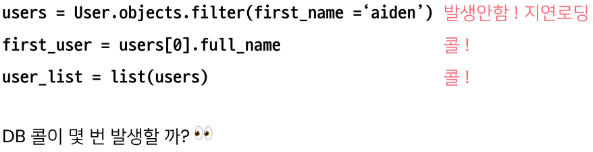

순서를 바꿨다면?  
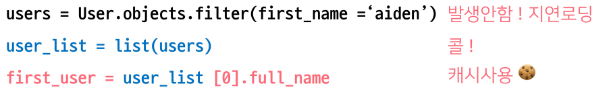

<b>Django ORM 특징</b>  

기본적으로 모든 ORM은 <font color="red">지연 로딩</font>이다.  
- 실제로 필요할 때 데이터베이스에서 데이터를 가져온다.  

ORM을 이용해서 가져온 데이터는 <font color="red">캐싱</font>된다.  

순서를 변경하는 것만으로 데이터베이스 콜을 줄일 수 있다.  
즉, ORM의 동작원리를 잘 알고 사용하는 것이 중요하다.  

<b>섣부른 최적화를 하지 말자</b>  

사실 Django ORM은 이미 충분히 똑똑하다.  
내가 eager loading을 하지않아도, 필요한 경우 알아서 하기도 한다.  

너무 느리다고 생각이 들면 그때 최적화를 시도할 것  
대부분의 경우데는 필요하지 않음  

직접 SQL을 출력하지 않아도,  
이쁘게 사용한 SQL을 보여주는 Django 전용 패키지가 많으니 필요시 찾아볼 것